In [1]:
from collections import namedtuple
import glob
from itertools import islice
from operator import lt, gt

from astropy.coordinates import Angle, SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import corner
from ebltable.tau_from_model import OptDepth
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18, 'figure.figsize': (14.0, 8.0)})
from numba import njit
import numpy as np
import pandas as pd
from scipy import integrate, interpolate, optimize, stats

In [2]:
# Read in the source selection catalog
whsp = pd.read_csv("3HSP_catalog.txt", comment='#', skiprows=[58, 59],
                   delimiter=' *\| *', engine='python', na_filter=False)
# Rename columns and source names for compatibility with the 2WHSP catalog file
whsp = whsp.rename(columns={"RAJ2000": "ra", "DEJ2000": "dec", "FOM": "figure_of_merit",
                            "lognufnu": "log_nu_f_nu", "WHSP": "name", "z": "whsp_z"})
whsp.name = whsp.name.str.replace("2WHSP", "2WHSP ")
whsp

,_RAJ2000,_DEJ2000,Name,ra,dec,sflag,BZCat,lognu,log_nu_f_nu,f_lognu,whsp_z,f_z,Gamma,figure_of_merit,name
0,00 01 16.3704,+29 35 34.692,3HSPJ000116.4+293534,0.31821,29.59297,1,,16.0,-12.9,2,0.5800,5,,0.05,2WHSP J000116.3+293534
1,00 01 17.0808,-31 50 43.800,3HSPJ000117.1-315043,0.32117,-31.84550,1,,15.5,-12.3,2,0.4500,4,,0.20,2WHSP J000116.9-315043
2,00 01 32.7408,-41 55 25.104,3HSPJ000132.7-415525,0.38642,-41.92364,4,,15.8,-11.7,1,,,4FGL J0001.6-4156,0.79,2WHSP J000132.6-415524
3,00 01 58.1400,-11 50 47.004,3HSPJ000158.1-115047,0.49225,-11.84639,1,,16.2,-12.5,1,0.5300,5,,0.13,2WHSP J000158.0-115047
4,00 02 15.1896,-67 26 53.412,3HSPJ000215.2-672653,0.56329,-67.44817,0,,15.8,-11.8,1,0.5200,3,4FGL J0002.1-6728,0.63,2WHSP J000215.1-672653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,23 59 21.3408,-13 11 29.292,3HSPJ235921.3-131129,359.83892,-13.19147,1,,15.7,-12.7,1,0.5600,5,,0.08,2WHSP J235921.3-131129
2009,23 59 55.3008,+31 46 00.012,3HSPJ235955.0+314600,359.98042,31.76667,0,,16.1,-12.0,1,0.3300,5,,0.40,2WHSP J235955.3+314600
2010,08 55 42.8472,+11 03 14.652,3HSPJ085542.8+110315,133.92853,11.05407,0,,15.8,-12.7,1,0.3000,1,,0.08,
2011,01 59 45.9000,+09 00 02.016,3HSPJ015945.9+090002,29.94125,9.00056,0,,15.0,-13.0,1,0.6300,5,,0.04,


In [3]:
# Define sky selection cuts
def sky_selection_cuts(ra, dec, ra_bounds=None, dec_bounds=None, b_bounds=None):
    """Applies selection cuts on sky coordinates
    
    RA, Dec, and bounds should be specified in degrees.
    Bounds should be expressed as lists of bounds tuples:
        [(lower_bound_1, upper_bound_1), (lower_bound_2, upper_bound_2)...]
    """
    cut_mask = np.ones(len(ra), dtype=bool)
    print("{} sources total".format(len(cut_mask)))
    if ra_bounds:
        ra_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in ra_bounds:
            ra_mask |= (lower <= ra[cut_mask]) & (ra[cut_mask] <= upper)
        cut_mask[cut_mask] &= ra_mask
        print("{} sources left after RA cut".format(sum(cut_mask)))
    if dec_bounds:
        dec_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in dec_bounds:
            dec_mask |= (lower <= dec[cut_mask]) & (dec[cut_mask] <= upper)
        cut_mask[cut_mask] &= dec_mask
        print("{} sources left after declination cut".format(sum(cut_mask)))
    if b_bounds:
        b = SkyCoord(ra=ra[cut_mask], dec=dec[cut_mask], unit='deg').galactic.b.value
        b_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in b_bounds:
            b_mask |= (lower < b) & (b < upper)
        cut_mask[cut_mask] &= b_mask
        print("{} sources left after Galactic latitude cut".format(sum(cut_mask)))
    return cut_mask

In [4]:
# Apply selection cuts to 2WHSP catalog
#ra_bounds = [((6*u.hourangle).to_value(u.degree), (10*u.hourangle).to_value(u.degree))]
ra_bounds = [((0*u.hourangle).to_value(u.degree), (24*u.hourangle).to_value(u.degree))]
dec_bounds = [(1.7, 61.7)]
b_bounds = [(-np.inf, -10), (10, np.inf)]
fom_cut = 2.0

cut_mask = sky_selection_cuts(whsp.ra, whsp.dec, ra_bounds=ra_bounds, dec_bounds=dec_bounds, b_bounds=b_bounds)
cut_mask[cut_mask] = whsp.figure_of_merit[cut_mask] > fom_cut
print("{} sources left after Figure of Merit cut".format(sum(cut_mask)))

2013 sources total
2013 sources left after RA cut
938 sources left after declination cut
884 sources left after Galactic latitude cut
36 sources left after Figure of Merit cut


In [5]:
# Calculate sky coverage (taking into account sky selection cuts only)
# The effects of the RA and Dec cuts are determined analytically,
# but the effect of the Galactic latitude cut is found using a Monte Carlo method,
# since that coordinate is not orthogonal to the first two

num_points = 1000000
coords = np.random.random([num_points, 2])

ra_lo, ra_hi = ra_bounds[0]
ra_fraction = (ra_hi - ra_lo) / 360
print("Fraction kept after RA cut: {:.04}".format(ra_fraction))
ra = (ra_hi - ra_lo)*coords[:,0] + ra_lo

dec_lo, dec_hi = (np.pi/180)*np.array(dec_bounds[0])
dec_fraction = (np.sin(dec_hi) - np.sin(dec_lo)) / 2
print("Fraction kept after Dec cut: {:.04}".format(dec_fraction))
dec = 180/np.pi*np.arcsin(2*np.sin((dec_hi - dec_lo)/2)*np.cos((dec_hi + dec_lo)/2)*coords[:,1] + np.sin(dec_lo))

b_fraction = sum(sky_selection_cuts(ra, dec, b_bounds=b_bounds)) / num_points
print("Fraction kept after Galactic latitude cut: {:.04}".format(b_fraction))

sky_coverage_const = ra_fraction * dec_fraction * b_fraction
print("Sky coverage: {:.04}".format(sky_coverage_const))

Fraction kept after RA cut: 1.0
Fraction kept after Dec cut: 0.4254
1000000 sources total
821136 sources left after Galactic latitude cut
Fraction kept after Galactic latitude cut: 0.8211
Sky coverage: 0.3493


In [6]:
# Since we required 2WHSP FoM > 1 (as opposed to >= 1),
# determine the synchrotron flux limit using the flux of the weakest possibly detected source
# Don't take into account the other cuts, since the cuts are independent
# 3HSP FOM of 2 is equivalent to 2WHSP FOM of 1

min_log_nu_f_nu = np.min(whsp.log_nu_f_nu[whsp.figure_of_merit > 2].to_numpy())
min_nu_f_nu = (10**min_log_nu_f_nu)*u.erg/(u.cm*u.cm)/u.s
print("Minimum log(nu F_nu) is {}, giving {:.04}".format(min_log_nu_f_nu, min_nu_f_nu))

Minimum log(nu F_nu) is -11.2, giving 6.31e-12 erg / (cm2 s)


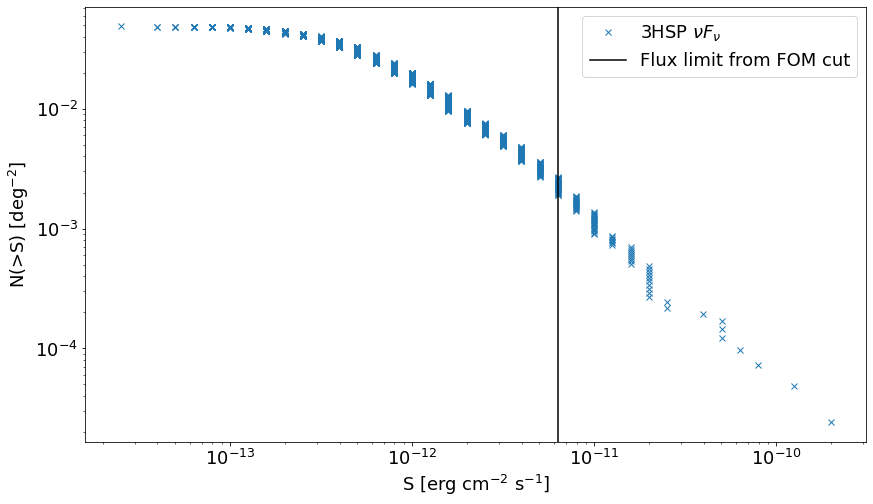

In [7]:
# Plot the logN-logS of the 3HSP sources, to show that the slope is constant in the selection region
def logN_logS(fluxes, sky_coverage_const=1.0, label=None):
    nums = np.array(range(len(fluxes), 0, -1)) / sky_coverage_const / (4*np.pi*u.sr).to_value(u.degree*u.degree)
    plt.plot(np.sort(fluxes), nums, marker='x', linestyle='none', label=label)
    plt.xscale('log')
    plt.xlabel("S [erg cm$^{-2}$ s$^{-1}$]")
    plt.yscale('log')
    plt.ylabel("N(>S) [deg$^{-2}$]")
    plt.legend()

logN_logS(10**whsp.log_nu_f_nu, label=r"3HSP $\nu F_{\nu}$")
plt.axvline(min_nu_f_nu.value, color='k', label="Flux limit from FOM cut")
plt.legend()
plt.savefig('whsp_logn_logs.png', bbox_inches='tight')
plt.savefig('whsp_logn_logs.pdf', bbox_inches='tight')

In [8]:
# Read in our data and join in to the selected 2WHSP sources
vts_data = pd.read_csv("LF_blazar_data_3hsp.csv")
raw_data = vts_data.join(whsp[cut_mask].set_index('name'), on='whsp_name', how='inner')

# Olivier calculated an average Mrk 501 flux of 23% Crab (it's listed as "variable" in TeVCat)
raw_data.loc[raw_data.source == "Mkn 501", 'tevcat_flux_crab'] = 0.23

raw_data

,source,whsp_name,z,archival_hours,year1_hours,legacy_hours,tevcat_flux_crab,tevcat_index,_RAJ2000,_DEJ2000,...,dec,sflag,BZCat,lognu,log_nu_f_nu,f_lognu,whsp_z,f_z,Gamma,figure_of_merit
0,RGB J0152+017,2WHSP J015239.5+014717,0.080,19.3,0.0,5,0.020,2.95,01 52 39.6000,+01 47 17.412,...,1.78817,0,5BZGJ0152+0147,15.9,-11.2,1,0.0800,1,4FGL J0152.6+0147,2.51
1,B3 0133+388,2WHSP J013632.5+390558,NaN,18.5,0.0,5,NaN,NaN,01 36 32.5896,+39 05 59.208,...,39.09978,0,5BZBJ0136+3905,16.1,-10.8,1,,,4FGL J0136.5+3906,6.31
2,1ES 0120+340,2WHSP J012308.5+342048,0.270,11.1,5.0,8,NaN,NaN,01 23 08.6304,+34 20 48.516,...,34.34681,0,5BZBJ0123+3420,18.0,-10.8,1,0.2700,1,4FGL J0123.1+3421,6.31
4,1ES 0229+200,2WHSP J023248.5+201717,0.139,198.6,18.0,0,0.018,2.50,02 32 48.6000,+20 17 17.304,...,20.28814,0,5BZGJ0232+2017,18.5,-11.0,1,0.1390,1,4FGL J0232.8+2018,3.98
6,1FGL J0333.7+2919,2WHSP J033349.0+291631,NaN,3.3,7.9,10,NaN,NaN,03 33 49.0008,+29 16 31.512,...,29.27542,0,5BZBJ0333+2916,15.2,-11.2,1,,,4FGL J0333.7+2916,2.51
7,RGB J0316+090,2WHSP J031612.7+090442,NaN,5.7,6.0,10,NaN,NaN,03 16 12.7296,+09 04 43.212,...,9.07867,0,5BZBJ0316+0904,15.3,-11.2,1,0.3720,2,4FGL J0316.2+0905,2.51
8,GB6 J0540+5823,2WHSP J054029.9+582338,NaN,2.8,8.7,16,NaN,NaN,05 40 30.0096,+58 23 38.400,...,58.39400,0,5BZBJ0540+5823,16.3,-11.2,1,,,4FGL J0540.5+5823,2.51
9,RGB J0710+591,2WHSP J071029.9+590820,0.120,166.2,0.0,0,0.030,2.69,07 10 30.0504,+59 08 20.508,...,59.13903,0,5BZBJ0710+5908,18.1,-10.7,1,0.1200,1,4FGL J0710.4+5908,7.94
10,1ES 0647+250,2WHSP J065046.3+250258,0.203,45.4,0.0,0,0.030,NaN,06 50 46.4808,+25 02 59.496,...,25.04986,0,5BZBJ0650+2502,16.7,-10.7,1,0.2030,2,4FGL J0650.7+2503,7.94
11,1ES 0806+524,2WHSP J080949.0+521857,0.137,63.5,0.0,0,0.018,2.65,08 09 49.1904,+52 18 58.284,...,52.31619,0,5BZBJ0809+5218,15.7,-10.9,1,0.1370,1,4FGL J0809.8+5218,5.01


In [9]:
def crab_flux_to_photon_flux(crab_flux, threshold_energy):
    # Hillas et al. (1998)
    # https://ui.adsabs.harvard.edu/abs/1998ApJ...503..744H/abstract
    crab_index= 2.49
    crab_norm = 3.2e-11/u.cm**2/u.s/u.TeV
    crab_E0 = 1.0 * u.TeV
    crab_photon_flux = (crab_norm * crab_E0 / (crab_index - 1)
                        * np.power(threshold_energy.to(u.TeV)/crab_E0, 1 - crab_index))
    return crab_flux * crab_photon_flux

def get_spectrum(flux, index, e_min, e_max, num_bins=60, e_0=1.*u.TeV, e_start=0.03*u.TeV, e_stop=30.*u.TeV):
    """Return the binned fluxes corresponding to the power law spectrum, given the spectral parameters
    
    Arguments:
        flux: Quantity, total flux of the source
        index: array, photon spectral index
        e_min: Quantity [energy], energy threshold of the spectrum
        e_max: Quantity [energy], maximum energy of the spectrum
        e_0: Quantity [energy], scale energy of the spectrum
        e_start: Quantity [energy], smallest energy to return
        e_stop: Quantity [energy], largest energy to return
        num_bins: int, number of flux bins to include in the spectrum
    
    Returns:
        spectrum: Quantity [flux.unit], binned fluxes from e_start to e_stop
        bin_edges: Quantity [TeV], sequence of length num_bins + 1 defining the bin energies
    """
    
    # Approxmate the spectrum as a sequence of energy bins
    # determined by the provided spectral parameters and integrated flux
    norm = flux * (index - 1) / e_0 / ((e_min/e_0)**(1 - index) - (e_max/e_0)**(1 - index))
    norm = np.expand_dims(norm, axis=1)
    bin_edges = np.geomspace(e_start.to_value(u.TeV), e_stop.to_value(u.TeV), num=(num_bins + 1))*u.TeV
    # The bin geometric center (ignoring the spectral index) is a good approximation for the bin average energy
    # in the limit of many small logarithmically spaced bins
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spectrum = (norm.to(1/(u.cm**2)/u.s/u.TeV) * bin_widths
                * np.power(bin_ctrs/e_0, -np.expand_dims(index, axis=1)))
    
    def beyond_bound(energy, op):
        return op(bin_ctrs.to_value(u.TeV), np.reshape(energy, (-1, 1)).to_value(u.TeV))
    
    spectrum[beyond_bound(e_min, lt) | beyond_bound(e_max, gt)] = 0

    return spectrum.to(flux.unit), bin_edges


tau = OptDepth.readmodel(model='dominguez')

def deabsorb_spectrum(spectrum, bin_edges, z):
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:]).to_value(u.TeV)
    return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))


def spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=False):
    deabs_spectrum = deabsorb_spectrum(spectrum, bin_edges, z) if deabsorb else spectrum
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    eflux = np.sum(deabs_spectrum * bin_ctrs, axis=1)
    return eflux


cosmo = FlatLambdaCDM(H0=70*(u.km/u.s/u.Mpc), Tcmb0=2.725*u.K, Om0=0.3)

def luminosity_to_eflux(luminosity, alpha, z):
    """Convert the luminosity to energy flux
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    eflux = luminosity / (4*np.pi * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, alpha - 1))
    return eflux.to(u.erg/(u.cm*u.cm)/u.s)


def eflux_to_luminosity(eflux, alpha, z):
    """Convert the energy flux to luminosity
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    luminosity = 4*np.pi * eflux * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, alpha - 1)
    return luminosity.to(u.erg/u.s)


def spectrum_to_luminosity(spectrum, bin_edges, index, z, deabsorb=False):
    eflux = spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=deabsorb)
    luminosity = eflux_to_luminosity(eflux, index, z)
    return luminosity

In [10]:
class veritas_instrument_response():
    """Performs calculations specific to the performance of the VERITAS instrument
    
    The constants are derived from Manel's VEGAS analysis of 1ES 1218+304, described here:
    https://veritas.sao.arizona.edu/wiki/images/6/6d/Vts_significance_estimate_ME.pdf

    The formulas are derived from Li & Ma eq. 9, making use of the following expressions:
    N_on = N_gamma + N_bg; N_off = N_bg/alpha
    N_gamma = R_gamma*(F/F_0)*t; N_bg = R_bg*t
    """
    
    alpha = 0.130897
    F_0 = 8.269e-8 * u.m**-2 * u.s**-1
    R_bg = 2.801 * u.min**-1
    R_gamma = 0.858 * u.min**-1
    sigma = 5

    
    def flux_error(self, flux, exposure):
        """Returns the flux error corresponding to the VERITAS measured flux and exposure
        
        Derived as 1/S.
        """
        factor1 = np.sqrt(self.R_bg/(self.R_gamma**2 * exposure))
        factor2 = np.sqrt(1 + self.alpha*(1 + (self.R_gamma/self.R_bg)*(flux/self.F_0)))
        flux_error = self.F_0 * factor1 * factor2
        return flux_error.to(flux.unit)
    
    
    def sensitivity(self, exposure):
        """Returns the flux equivalent to the VERITAS sensitivity at the given exposure
    
        Derived by solving the equation for S as a function of t.
        """
        
        prefactor = (self.alpha * self.sigma**2 * self.F_0) / (2 * self.R_gamma * exposure)
        inner_factor = 4 * ((1 + self.alpha)/self.alpha**2) * ((self.R_bg * exposure)/self.sigma**2)
    
        flux = prefactor * (1 + np.sqrt(1 + inner_factor))
        return flux.to(u.cm**-2 * u.s**-1)
    
irf = veritas_instrument_response()

In [11]:
# Define constant assumed values for the analysis

# The SED is flat at the synchrotron peak -> spectral index = 1
synchrotron_peak_index = 1

# Since we're using fluxes from TeVCat, we don't have the actual spectra
e_min = 0.2*u.TeV
e_start = 0.03*u.TeV
e_stop = 30.*u.TeV
num_bins = 60  # Number of spectral bins (20 per decade)


def process_veritas_data(raw_data, dataset, seed=None):
    """Process raw VERITAS data into a dataframe suitable for plotting distributions
    
    For unknown quantities, generate random values by drawing from a simple assumed distribution.
    """
    
    df = pd.DataFrame()
    units = {}
    labels = {}
    
    # Account for unknown/uncertain flux, index, and redshift values
    # by sampling from assumed simple distributions
    
    def simulate_flux(crab_flux, e_min, seed=None):
        if seed is not None:
            np.random.seed(seed)
        tevcat = ~np.isnan(crab_flux)
        tevcat_flux = crab_flux_to_photon_flux(crab_flux, e_min)
        non_tevcat_flux = crab_flux_to_photon_flux(0.01, e_min)
        mean = np.where(tevcat, tevcat_flux, non_tevcat_flux)
        std = np.where(tevcat, tevcat_flux/2, non_tevcat_flux)
        # Simulate intrinsic flux uncertainty/variability
        deviation = np.random.normal(0, std)*tevcat_flux.unit
        # Allow the flux to be less than the TeVCat flux, but not greater,
        # to account for bias towards flares
        deviation = np.where(tevcat, np.abs(deviation), deviation)
        return np.clip(mean - deviation, 0, None)
    
    def simulate_index(index):
        tevcat = ~np.isnan(index)
        mean = np.where(tevcat, index, 3.5)
        return np.clip(np.random.normal(mean, 0.5), 1.5, None)
    
    
    def simulate_redshift(z):
        tevcat = ~np.isnan(z)
        simulated_z = np.where(tevcat, z, np.random.normal(0.4, 0.1, z.shape))
        return np.clip(simulated_z, 0, None)
    
    
    def simulate_veritas_observing(flux, exposure, dataset, e_min, seed=None):
        """Simulate errors on the flux and flux-dependent exposure strategy, if applicable"""
        if seed is not None:
            np.random.seed(seed)
        if dataset in ['archival', 'year1', 'legacy']:
            # Simulate VERITAS flux measurement error
            error = np.random.normal(flux, irf.flux_error(flux, exposure))*flux.unit
            measured_flux = flux + error
            final_exposure = exposure
        elif dataset == 'legacy-plus':
            # Take "first pass" data (similar to allocations in LF moonshot as is)
            # Exposure thresholds correspond to 30 and 10 hours with a usable archival frac of 0.7
            conditions = [exposure >= 21*u.hr, (exposure < 21*u.hr) & (exposure >= 7*u.hr), exposure < 7*u.hr]
            choices = [0, 6, 8]*u.hr
            lf_exposure = np.select(conditions, choices)
            first_pass_exposure = exposure + lf_exposure
            first_pass_error = np.random.normal(flux, irf.flux_error(flux, first_pass_exposure))*flux.unit
            first_pass_measured_flux = flux + first_pass_error
            # Take "second pass" exposures allocating additional time to confirm possible detections
            flux_threshold = crab_flux_to_photon_flux(0.012, e_min)
            second_pass_condition = (first_pass_measured_flux > flux_threshold) & (first_pass_exposure < 20*u.hr)
            second_pass_exposure = np.where(second_pass_condition, 24*u.hr, first_pass_exposure)
            second_pass_error = np.random.normal(flux, irf.flux_error(flux, second_pass_exposure))*flux.unit
            second_pass_measured_flux = flux + second_pass_error
            measured_flux, final_exposure = second_pass_measured_flux, second_pass_exposure
        else:
            raise ValueError("invalid dataset: {}".format(dataset))
        return np.clip(measured_flux, 0, None), final_exposure
    
    
    usable_archival_frac = 0.7
    datasets = {
        'archival': 0*u.hr,
        'year1': raw_data.year1_hours.to_numpy()*u.hr,
        'legacy': raw_data.legacy_hours.to_numpy()*u.hr,
        'legacy-plus': 0*u.hr,
    }
    flux = simulate_flux(raw_data.tevcat_flux_crab.to_numpy(), e_min, seed)
    archival_exposure = raw_data.archival_hours.to_numpy()*usable_archival_frac*u.hr
    exposure = archival_exposure + datasets[dataset]
    flux, exposure = simulate_veritas_observing(flux, exposure, dataset, e_min, seed)
    print("Total archival exposure: {:.05}".format(np.sum(archival_exposure)))
    print("Total LF exposure: {:.05}".format(np.sum(exposure - archival_exposure)))
    
    inputs = {
        'flux': (flux.value, flux.unit, "TeV Flux\n[ph cm$^{-2}$ s$^{-1}$]"),
        'whsp_flux': (10**raw_data.log_nu_f_nu.to_numpy(), u.erg/(u.cm**2)/u.s,
                      "Synchrotron Flux\n[erg cm$^{-2}$ s$^{-1}$]"),
        'index': (simulate_index(raw_data.tevcat_index.to_numpy()), u.dimensionless_unscaled,
                  "Spectral Index"),
        'z': (simulate_redshift(raw_data.z.to_numpy()), u.dimensionless_unscaled, "Redshift"),
        'exposure': (exposure.value, exposure.unit, "Exposure\n[hr]"),
        'fom': (raw_data.figure_of_merit.to_numpy(), u.dimensionless_unscaled, "3HSP Figure of Merit"),
    }
    
    mask = (inputs['flux'][0] > 0) & (inputs['z'][0] > 0)
    print("{}/{} sources with zero simulated flux excluded from the analysis.".format(sum(~mask), len(mask)))

    for key in inputs:
        df[key], units[key], labels[key] = inputs[key][0][mask], *inputs[key][1:]
            
    return df, units, labels


def calculate_luminosity(processed_data, processed_units, processed_labels):
    """Calculate the luminosity and related quantities using the processed data"""
    
    def value(key):
        return processed_data[key].to_numpy() * processed_units[key]
    
    df = pd.DataFrame()
    units = {}
    labels = {}
    
    e_max = u.TeV/(3*value('z')) # Estimate e_max using as inversely scaled with redshift
    spectrum, bin_edges = get_spectrum(value('flux'), value('index'), e_min=e_min, e_max=e_max,
                                       e_start=e_start, e_stop=e_stop, num_bins=num_bins)
    alpha = value('index') - 1
    
    outputs = {
        'whsp_luminosity': (eflux_to_luminosity(value('whsp_flux'), synchrotron_peak_index, value('z')),
                            "Synchrotron Luminosity\n[erg s$^{-1}$]"),
        'tev_eflux': (spectrum_to_eflux(spectrum, bin_edges, value('z'), deabsorb=False),
                      "TeV Energy Flux\n[erg cm$^{-2}$ s$^{-1}$]"),
        'obs_luminosity': (spectrum_to_luminosity(spectrum, bin_edges, alpha, value('z'), deabsorb=False),
                               "TeV Observed Luminosity\n[erg s$^{-1}$]"),
        'deabs_luminosity': (spectrum_to_luminosity(spectrum, bin_edges, alpha, value('z'), deabsorb=True),
                                 "TeV Deabsorbed Luminosity\n[erg s$^{-1}$]")
    }
    
    for key in outputs:
        df[key], labels[key] = outputs[key]
        units[key] = outputs[key][0].unit
    
    return df, units, labels

def generate_data(raw_data, dataset, seed=None):
    """Load VERITAS data (randomly sampling from distributions) and derive quantities from it"""
    
    proc_data, proc_units, proc_labels = process_veritas_data(raw_data, dataset, seed)
    lum_data, lum_units, lum_labels = calculate_luminosity(proc_data, proc_units, proc_labels)
    data = pd.concat((proc_data, lum_data), axis=1)
    units, labels = {**proc_units, **lum_units}, {**proc_labels, **lum_labels}

    def value(key):
        return data[key].to_numpy() * units[key]

    return data, labels, value

Total archival exposure: 1293.3 h
Total LF exposure: 273.59 h
4/36 sources with zero simulated flux excluded from the analysis.
Min/max obs_luminosity: 1.612e+42 erg / s, 4.619e+46 erg / s
Min/max deabs_luminosity: 5.715e+42 erg / s, 2.293e+47 erg / s
Min/max z: 0.03, 0.4944
Mean exposure: 42.87 h
Mean index: 3.552


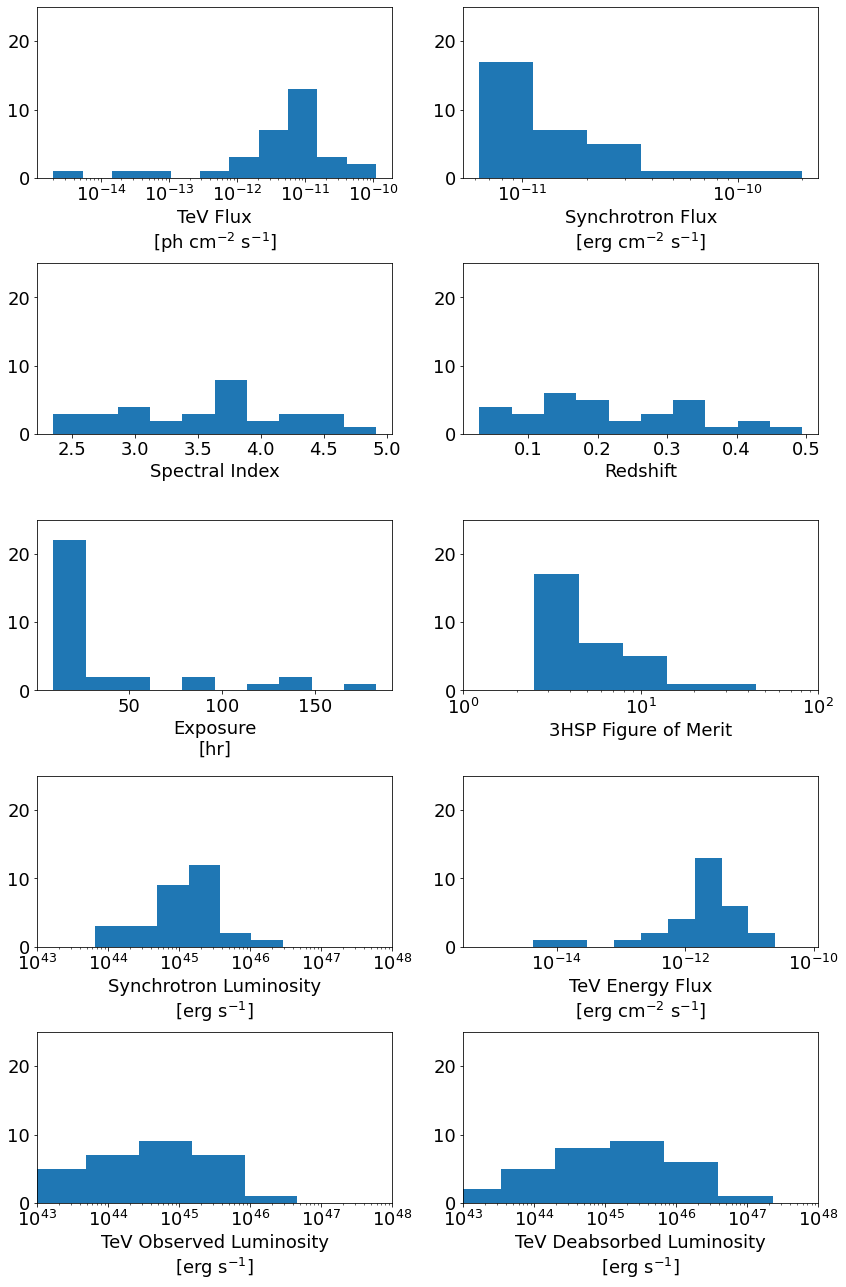

In [12]:
# dataset = 'archival', year1', 'legacy', or 'legacy-plus'
np.random.seed(0)
data, labels, value = generate_data(raw_data, dataset='legacy-plus')

for key in ['obs_luminosity', 'deabs_luminosity', 'z']:
    print("Min/max {}: {:.04}, {:.04}".format(key, np.min(value(key)), np.max(value(key))))
mean_exposure = np.mean(value('exposure'))
print("Mean exposure: {:.04}".format(mean_exposure))
mean_index = np.mean(value('index')).reshape(1)
print("Mean index: {:.04}".format(mean_index[0]))

# Plot distributions of the data
fig, axes = plt.subplots(5, 2, figsize=(14.0, 22.0))
for ax, (key, arr), label in zip(axes.ravel(), data.iteritems(), labels.values()):
    if key in ['index', 'z', 'exposure']:
        bins = 10
    else:
        _, bins = np.histogram(np.log10(arr), bins='auto')
        bins = 10**bins
        ax.set_xscale('log')
    ax.hist(arr, bins=bins)
    if key in ['whsp_luminosity', 'obs_luminosity', 'deabs_luminosity']:
        ax.set_xlim(1e43, 1e48)
    if key == 'fom':
        ax.set_xlim(1, 100)
    ax.set_ylim(0, 25)
    ax.set_xlabel(label)
plt.subplots_adjust(hspace=0.5)
plt.savefig('dataset_distributions.png', bbox_inches='tight')
plt.savefig('dataset_distributions.pdf', bbox_inches='tight')

In [13]:
def limiting_eflux_to_redshift(eflux, luminosity, index):
    num_zs = 250
    zs = np.linspace(0.0, 0.02*num_zs, num_zs)
    efluxes = np.zeros((len(luminosity), num_zs)) * eflux.unit
    for i, z in enumerate(zs):
        efluxes[:, i] = luminosity_to_eflux(luminosity, index, z)
    differences = np.abs(efluxes - np.expand_dims(eflux, axis=1))
    return zs[np.nanargmin(differences, axis=1)].flatten()*u.dimensionless_unscaled


def limiting_spectrum_to_redshift(spectrum, bin_edges, luminosity, index):
    num_zs = 125
    zs = np.linspace(0.0, 0.01*num_zs, num_zs)
    luminosities = np.zeros((len(luminosity), num_zs)) * luminosity.unit
    for i, z in enumerate(zs):
        luminosities[:, i] = spectrum_to_luminosity(spectrum, bin_edges, index, z,
                                                    deabsorb=True).to(luminosity.unit)
    differences = np.abs(luminosities - np.expand_dims(luminosity, axis=1))
    limiting_redshift = np.zeros(luminosity.shape)
    good = ~np.isnan(np.nanmin(differences, axis=1))
    limiting_redshift[good] = zs[np.nanargmin(differences[good], axis=1)].flatten()*u.dimensionless_unscaled
    return limiting_redshift

/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


22/32 sources detected.
Redshift: [0.08       0.49444795 0.27       0.35384154 0.39317584 0.12
 0.203      0.137      0.198      0.278      0.35       0.03
 0.2        0.138      0.143      0.33       0.18       0.218
 0.135      0.31       0.443      0.129      0.16       0.24
 0.344      0.03       0.055      0.18       0.3        0.119
 0.065      0.40174792]
TeV limiting redshift: [0.07056452 0.46370968 0.14112903 0.41330645 0.10080645 0.22177419
 0.29233871 0.19153226 0.26209677 0.24193548 0.37298387 0.12096774
 0.30241935 0.17137097 0.15120968 0.39314516 0.06048387 0.29233871
 0.22177419 0.36290323 0.08064516 0.18145161 0.2016129  0.27217742
 0.27217742 0.09072581 0.09072581 0.23185484 0.35282258 0.09072581
 0.07056452 0.57459677]
3HSP limiting redshift: [0.08032129 0.72289157 0.40160643 0.36144578 0.40160643 0.20080321
 0.34136546 0.18072289 0.20080321 0.34136546 0.3815261  0.16064257
 0.34136546 0.18072289 0.18072289 0.36144578 0.2811245  0.22088353
 0.22088353 0.46184739 0.943

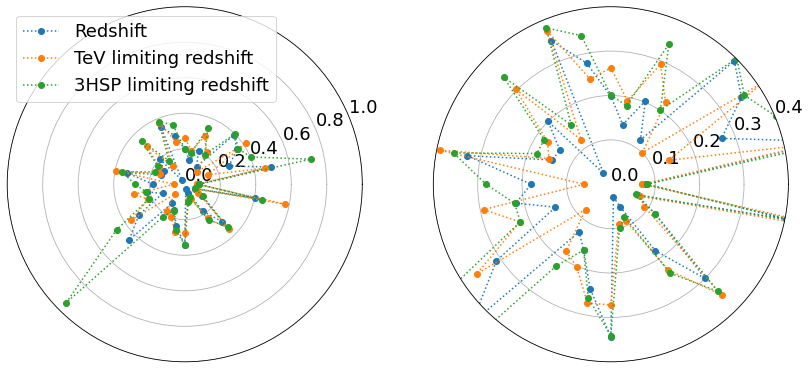

In [14]:
# Compare the limiting redshifts from the actual VERITAS observations
# to those from the selection flux limit

def calculate_limiting_redshifts(value, min_nu_f_nu=min_nu_f_nu, synchrotron_peak_index=synchrotron_peak_index,
                                 e_min=e_min, num_bins=num_bins):
    limiting_whsp_fluxes = np.ones(value('whsp_luminosity').size) * min_nu_f_nu
    limiting_whsp_z = limiting_eflux_to_redshift(limiting_whsp_fluxes, value('whsp_luminosity'),
                                                 synchrotron_peak_index)
    limiting_vts_fluxes = irf.sensitivity(value('exposure'))
    limiting_vts_spectra, limiting_vts_bin_edges = get_spectrum(limiting_vts_fluxes, value('index'),
                                                                e_min=e_min, e_max=u.TeV/(3*value('z')),
                                                                num_bins=num_bins)
    limiting_tev_z = limiting_spectrum_to_redshift(limiting_vts_spectra, limiting_vts_bin_edges,
                                                   value('deabs_luminosity'), value('index'))
    
    zs = {
        "Redshift": value('z'),
        "TeV limiting redshift": limiting_tev_z,
        "3HSP limiting redshift": limiting_whsp_z
    }

    min_z = np.minimum(limiting_whsp_z, limiting_tev_z)
    detected = value('z') <= min_z
    print("{}/{} sources detected.".format(sum(detected), len(min_z)))
    
    return zs, min_z, detected

zs, min_z, detected = calculate_limiting_redshifts(value)

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})
for ax in axes:
    for label, arr in zs.items():
        print("{}: {}".format(label, arr))
        polar_x = (2*np.pi / arr.size)*np.arange(arr.size + 1)
        ax.plot(polar_x, np.append(arr, arr[0]), linestyle=':', marker='o', label=label)
        ax.set_xticks([])
axes[0].set_ylim((0, 1.0))
axes[0].set_yticks(np.arange(0, 1.1, step=0.2))
axes[1].set_ylim((0, 0.4))
axes[1].set_yticks(np.arange(0, 0.5, step=0.1))
axes[0].legend(loc='upper left')
plt.savefig('limiting_z.png', bbox_inches='tight')
plt.savefig('limiting_z.pdf', bbox_inches='tight')

In [15]:
# Define LF functional forms to test different models, following a simplified version of Ajello et al. (2014)
# The following simplifications are made:
#   Omit dependence on the spectral index 
#   Use a single power law corresponding to the higher-luminosity region instead of a smoothly broken power law
#   Test only PLE and PDE models, not LDDE


@njit
def lf_smoothly_broken_pl_base(log10_L, *args):
    log10_A, index_1, log_L_break, index_2 = args
    A, L_break = 10**log10_A, np.exp(log_L_break)
    L = 10**(log10_L - 46)
    return A / np.log(10) / L / ((L/L_break)**index_1 + (L/L_break)**index_2)


@njit
def lf_pl_base(log10_L, *args):
    log10_A, index = args
    A = 10**log10_A
    L = 10**(log10_L - 46)  # L_scale = 1e46 erg/s
    return A / np.log(10) * np.power(L, -index - 1)


def evolution_factor_factory(evolution_params, fixed_xi=-0.3):
    
    evolution_param_dict = {
        'none': (False, False, False),
        'k': (True, False, False),
        'k_xi': (True, True, False),
        'k_tau': (True, False, True),
        'k_xi_tau': (True, True, True),
    }
    use_k, use_xi, use_tau = evolution_param_dict[evolution_params]
        
    @njit
    def evolution_factor(log10_L, z, *args):
        if use_k and use_tau:
            k_term = np.power(1 + z, args[0] + args[int(use_xi) + 1]*(log10_L - 46))
        elif use_k:
            k_term = np.power(1 + z, args[0])
        else:
            k_term = 1
        if use_xi:
            exp_term = np.exp(z/args[int(use_k)])
        else:
            exp_term = 1
        return k_term * exp_term
    
    return evolution_factor


def model_factory(base_model, evolution_model, evolution_params, split_idx):
    
    base_models = {
        'power_law': lf_pl_base,
        'smoothly_broken_power_law': lf_smoothly_broken_pl_base,
    }
    base_fn = base_models[base_model]
    evolution_factor = evolution_factor_factory(evolution_params)
    
    def model(log10_L, z, *args):
        base_args, evolution_args = args[:split_idx], args[split_idx:]
        if evolution_model == "pde":  # pure density evolution
            return base_fn(log10_L, *base_args) * evolution_factor(log10_L, z, *evolution_args)
        elif evolution_model == "ple":  # pure luminosity evolution
            return base_fn(log10_L - np.log10(evolution_factor(log10_L, z, *evolution_args)), *base_args)
        else:
            raise ValueError("unknown evolution {}".format(evolution))
        
    return model

In [16]:
# Define model-independent functions used for the optimization & fitting

# To construct the sky coverage, need to assume a standard spectral index (since the dependence was omitted)
# and constant exposure for every source
# Future work could derive from VERITAS observations an exposure probability distribution as a function of L, z
def detectable_volume_factory(zs, assumed_exposure, assumed_index, deabsorb=True, cutoff_exponent=10):
    """Precompute sky coverage function and comoving volume as a function of z"""
    assumed_limiting_flux = irf.sensitivity(assumed_exposure)
    limiting_spectrum, limiting_bin_edges = get_spectrum(assumed_limiting_flux, assumed_index, e_min=e_min,
                                                         e_max=u.TeV/(3*zs))
    limiting_luminosities = spectrum_to_luminosity(limiting_spectrum, limiting_bin_edges, assumed_index, zs,
                                                   deabsorb=deabsorb).value
    np.nan_to_num(limiting_luminosities, nan=np.inf, copy=False)
    comoving_volumes = cosmo.differential_comoving_volume(zs).value
    
    @njit
    def detectable_volume(L, z):
        limiting_luminosity = np.interp(z, zs, limiting_luminosities)
        sky_coverage = sky_coverage_const / (1 + (limiting_luminosity/L)**cutoff_exponent)
        comoving_volume = np.interp(z, zs, comoving_volumes)
        return 4*np.pi * sky_coverage * comoving_volume
    
    return detectable_volume


def poisson_lambda(log10_L, z, model, detectable_volume, *args):
    return model(log10_L, z, *args) * detectable_volume(10**log10_L, z)


@njit
def log_prior(args, arg_limits):
    for arg, limits in zip(args, arg_limits):
        if not limits[0] < arg < limits[1]:
            return -np.inf
    return 0


def log_likelihood_factory(model, assumed_exposure, assumed_index, ranges, arg_limits):
        
    limiting_zs = np.logspace(-2, 0, 400)
    detectable_volume = detectable_volume_factory(limiting_zs, assumed_exposure, assumed_index)
    
    def log_likelihood(args, log10_Ls, zs):
        poisson_lambda_args = (model, detectable_volume) + tuple(args)
        term_1 = 2*np.sum(np.log(model(log10_Ls, zs, *args) * cosmo.differential_comoving_volume(zs).value))
        term_2 = -2*integrate.nquad(poisson_lambda, ranges, args=poisson_lambda_args, opts={'epsabs': np.inf})[0]
        lp = log_prior(args, arg_limits)
        return np.nan_to_num(lp + term_1 + term_2, nan=np.inf)
                
    return log_likelihood

In [17]:
luminosity_type = 'deabs_luminosity'  # 'deabs_luminosity' or 'obs_luminosity'
args = (np.log10(value(luminosity_type).value[detected]), value('z').value[detected])
integration_ranges = tuple((np.min(arg), np.max(arg)) for arg in args)

# Parameter name, initial value, transform to apply, corresponding reverse transform
Param = namedtuple('Param', ['name', 'unit', 'initial_value', 'limits', 'forward_transform', 'reverse_transform'])
pl_params = [Param('A', u.Mpc**-3 * u.s/u.erg, 1e-8, (0, 1), np.log10, lambda x: 10**x),
             Param(r'$\gamma$', u.dimensionless_unscaled, -0.5, (-.999, 10), lambda x: x, lambda x: x)]
smoothly_broken_pl_params = [Param('L_break', u.erg/u.s, 1e47, (1e40, 1e50), lambda x: np.log(x / 1e46),
                                   lambda x: 1e46*np.exp(x)),
                             Param('beta', u.dimensionless_unscaled, 0, (-.999, 10), lambda x: x, lambda x: x)]
k_param = Param('k', u.dimensionless_unscaled, -7, (-100, 100), lambda x: x, lambda x: x)
xi_param = Param('xi', u.dimensionless_unscaled, 0, (-10, 10), lambda x: x, lambda x :x)
tau_param = Param('tau', u.dimensionless_unscaled, 0, (-100, 100), lambda x: x, lambda x: x)


def define_params(base_model, evolution_params):
    bases = {
        'power_law': pl_params,
        'smoothly_broken_power_law': pl_params + smoothly_broken_pl_params,
    }
    evolutions = {
        'none': [],
        'k': [k_param],
        'k_xi': [k_param, xi_param],
        'k_tau': [k_param, tau_param],
        'k_xi_tau': [k_param, xi_param, tau_param],
    }
    params = bases[base_model] + evolutions[evolution_params]
    split_idx = len(bases[base_model])
    return params, split_idx

In [18]:
# Calculate density-weighted V_max to account for evolution 

def weighted_v_max(z_max, log10_L, evolution_args, evolution_factor, detectable_volume, z_min=0):
        
    def integrand(z, *args):
        log10_L, z_min, *evolution_args = args
        norm = evolution_factor(log10_L, z_min, *evolution_args)
        return detectable_volume(10**log10_L, z) * evolution_factor(log10_L, z, *evolution_args) / norm
    
    v_max = integrate.quad(integrand, z_min, z_max, args=tuple([log10_L, z_min, *evolution_args]),
                           epsabs=np.inf)[0]
    return v_max


def calculate_lf_v_max(luminosity, z, evolution_params, evolution_param_values, detectable_volume,
                       luminosity_bins):
    weight_args = [z.value[detected], np.log10(luminosity.value)]
    evolution_factor = evolution_factor_factory(evolution_params)
    weighted_v_maxes = np.array([weighted_v_max(z_max, log10_L, evolution_param_values, evolution_factor,
                                                detectable_volume)
                                 for z_max, log10_L in zip(*weight_args)])*u.Mpc**3
    weighted_density = 1 / weighted_v_maxes
    
    bin_idxs = np.digitize(luminosity.value, luminosity_bins) - 1
    pts, pt_errs = [], []
    for i, lum_bin in enumerate(luminosity_bins[:-1]):
        bin_size = np.log(luminosity_bins[i + 1]) - np.log(luminosity_bins[i])
        pts.append(np.sum(weighted_density[bin_idxs == i].value) / bin_size)
        pt_errs.append(np.sqrt(np.sum(weighted_density[bin_idxs == i].value**2)) / bin_size)
    pts, pt_errs = np.array(pts), np.array(pt_errs)

    return pts, pt_errs

<ipython-input-19-bdb7840e08f0>:26: RuntimeWarning: divide by zero encountered in log10
  param_limits = np.array([param.forward_transform(param.limits) for param in params])
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Analyzing sample 1...
Total archival exposure: 1293.3 h
Total LF exposure: 273.59 h
7/36 sources with zero simulated flux excluded from the analysis.
21/29 sources detected.
<V/V_max> = 0.563 +- 0.063
Running MCMC...


N/50 = 35;
tau: [49.95911613 49.54455109 49.48758788]


Mean acceptance fraction: 0.632
Mean autocorrelation time: 49.664 steps


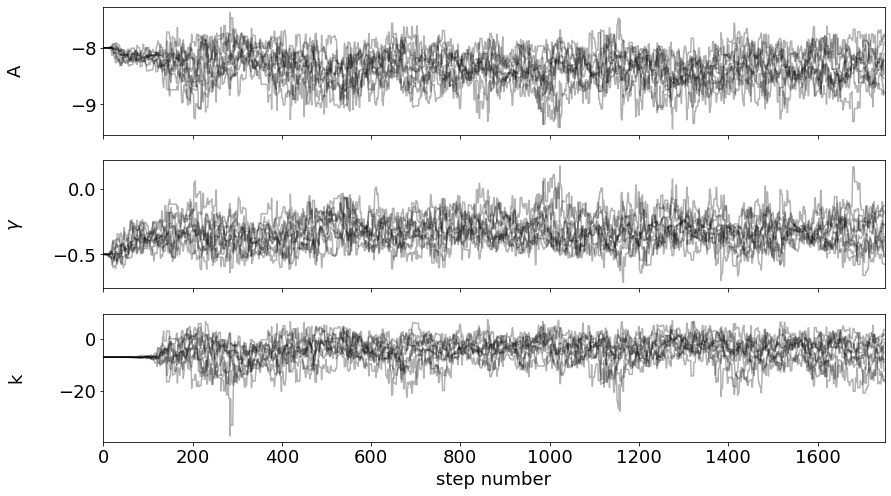

<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



Analyzing sample 2...
Total archival exposure: 1293.3 h
Total LF exposure: 298.21 h
1/36 sources with zero simulated flux excluded from the analysis.
29/35 sources detected.
<V/V_max> = 0.571 +- 0.054
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 3...
Total archival exposure: 1293.3 h
Total LF exposure: 326.15 h
2/36 sources with zero simulated flux excluded from the analysis.
29/34 sources detected.
<V/V_max> = 0.618 +- 0.054
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 4...
Total archival exposure: 1293.3 h
Total LF exposure: 277.05 h
3/36 sources with zero simulated flux excluded from the analysis.
24/33 sources detected.
<V/V_max> = 0.593 +- 0.059
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 5...
Total archival exposure: 1293.3 h
Total LF exposure: 291.09 h
0/36 sources with zero simulated flux excluded from the analysis.
27/36 sources detected.
<V/V_max> = 0.596 +- 0.056
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 6...
Total archival exposure: 1293.3 h
Total LF exposure: 300.76 h
4/36 sources with zero simulated flux excluded from the analysis.
27/32 sources detected.
<V/V_max> = 0.583 +- 0.056
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 7...
Total archival exposure: 1293.3 h
Total LF exposure: 260.48 h
3/36 sources with zero simulated flux excluded from the analysis.
20/33 sources detected.
<V/V_max> = 0.542 +- 0.065
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 8...
Total archival exposure: 1293.3 h
Total LF exposure: 305.71 h
1/36 sources with zero simulated flux excluded from the analysis.
29/35 sources detected.
<V/V_max> = 0.643 +- 0.054
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 9...
Total archival exposure: 1293.3 h
Total LF exposure: 322.48 h
1/36 sources with zero simulated flux excluded from the analysis.
26/35 sources detected.
<V/V_max> = 0.617 +- 0.057
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 10...
Total archival exposure: 1293.3 h
Total LF exposure: 325.87 h
4/36 sources with zero simulated flux excluded from the analysis.
25/32 sources detected.
<V/V_max> = 0.611 +- 0.058
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 11...
Total archival exposure: 1293.3 h
Total LF exposure: 283.64 h
3/36 sources with zero simulated flux excluded from the analysis.
23/33 sources detected.
<V/V_max> = 0.561 +- 0.060
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 12...
Total archival exposure: 1293.3 h
Total LF exposure: 310.64 h
0/36 sources with zero simulated flux excluded from the analysis.
26/36 sources detected.
<V/V_max> = 0.586 +- 0.057
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 13...
Total archival exposure: 1293.3 h
Total LF exposure: 317.72 h
4/36 sources with zero simulated flux excluded from the analysis.
24/32 sources detected.
<V/V_max> = 0.606 +- 0.059
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 14...
Total archival exposure: 1293.3 h
Total LF exposure: 257.23 h
3/36 sources with zero simulated flux excluded from the analysis.
25/33 sources detected.
<V/V_max> = 0.586 +- 0.058
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 15...
Total archival exposure: 1293.3 h
Total LF exposure: 315.76 h
0/36 sources with zero simulated flux excluded from the analysis.
24/36 sources detected.
<V/V_max> = 0.577 +- 0.059
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 16...
Total archival exposure: 1293.3 h
Total LF exposure: 291.86 h
2/36 sources with zero simulated flux excluded from the analysis.
25/34 sources detected.
<V/V_max> = 0.641 +- 0.058
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 17...
Total archival exposure: 1293.3 h
Total LF exposure: 326.78 h
1/36 sources with zero simulated flux excluded from the analysis.
25/35 sources detected.
<V/V_max> = 0.581 +- 0.058
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 18...
Total archival exposure: 1293.3 h
Total LF exposure: 317.65 h
1/36 sources with zero simulated flux excluded from the analysis.
25/35 sources detected.
<V/V_max> = 0.535 +- 0.058
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 19...
Total archival exposure: 1293.3 h
Total LF exposure: 276.18 h
2/36 sources with zero simulated flux excluded from the analysis.
25/34 sources detected.
<V/V_max> = 0.613 +- 0.058
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l


Analyzing sample 20...
Total archival exposure: 1293.3 h
Total LF exposure: 307.49 h
1/36 sources with zero simulated flux excluded from the analysis.
27/35 sources detected.
<V/V_max> = 0.634 +- 0.056
Running MCMC...


/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-9-92e28e60ec7e>:53: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/miniconda3/envs/sci/l

In [19]:
# Estimate the effect of uncertaintities in the data by repeated sampling

dataset = 'legacy-plus'  # 'year1', 'legacy', or 'legacy-plus'
luminosity_type = 'deabs_luminosity'  # 'deabs_luminosity' or 'obs_luminosity'
base_model = "power_law"
evolution_model = "ple"
evolution_params = "k"

num_data_samples = 20
num_walkers = 10
num_steps = 1750
num_discard = 250
num_thin = 50

# Constant luminosity and redshift intervals for plotting and calculations
min_log10_L, max_log10_L = 43, 48
luminosities = np.logspace(min_log10_L, max_log10_L, 100)
bins = np.logspace(min_log10_L, max_log10_L, max_log10_L - min_log10_L + 1)
bin_centers = stats.gmean(np.stack([bins[:-1], bins[1:]]), axis=0)
bin_errs = np.stack([bin_centers - bins[:-1], bins[1:] - bin_centers])
limiting_zs = np.logspace(-2, 0, 400)

# Define the model
params, param_split_idx = define_params(base_model, evolution_params)
initial_params = tuple(param.forward_transform(param.initial_value) for param in params)
param_limits = np.array([param.forward_transform(param.limits) for param in params])
model = model_factory(base_model, evolution_model, evolution_params, param_split_idx)

curves = []
samples = []
v_over_v_max = []
v_over_v_max_err = []
density_pts = []
density_pt_errs = []
num_detected = []
min_detected_flux = []

num_samples_analyzed = 0
while num_samples_analyzed < num_data_samples:
    print("Analyzing sample {}...".format(num_samples_analyzed + 1))
    data, labels, value = generate_data(raw_data, dataset=dataset, seed=num_samples_analyzed)
    
    min_z, detected = calculate_limiting_redshifts(value)[1:]
        
    num_detected.append(sum(detected))
    min_detected_flux.append(np.min(value('flux')[detected].value))
    
    v = cosmo.comoving_volume(value('z').value[detected]) * sky_coverage_const
    v_max = cosmo.comoving_volume(min_z.value[detected]) * sky_coverage_const
    v_over_v_max.append([np.mean(v/v_max)])
    v_over_v_max_err.append([np.sqrt(1/(12*sum(detected)))])
    print("<V/V_max> = {:.3f} +- {:.3f}".format(v_over_v_max[-1][0], v_over_v_max_err[-1][0]))
    
    args = (np.log10(value(luminosity_type).value[detected]), value('z').value[detected])
    integration_ranges = tuple((np.min(arg), np.max(arg)) for arg in args)
    
    mean_exposure, mean_index = np.mean(value('exposure')), np.mean(value('index')).reshape(1)
    log_likelihood = log_likelihood_factory(model, mean_exposure, mean_index, integration_ranges, param_limits)
    ndim = len(initial_params)
    p0 = np.array(initial_params) + 1e-4 * np.random.randn(num_walkers, ndim)

    sampler = emcee.EnsembleSampler(num_walkers, ndim, log_likelihood, args=args)
    print("Running MCMC...")
    sampler.run_mcmc(p0, num_steps)
    
    # Verify that the MCMC is working properly
    if num_samples_analyzed == 0:
        print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
        print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time(quiet=True))))

        all_samples = sampler.get_chain()

        fig, axes = plt.subplots(ndim, sharex=True)
        param_labels = [param.name for param in params]
        for i, ax in enumerate(axes):
            ax.plot(all_samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(all_samples))
            ax.set_ylabel(param_labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("step number")
        plt.savefig("chain.png", bbox_inches='tight')
        plt.savefig("chain.pdf", bbox_inches='tight')
        plt.show()
    
    # Save the samples for the LF calculation
    data_sample_samples = sampler.get_chain(discard=num_discard, thin=num_thin, flat=True)
    for sample in data_sample_samples:
        curves.append(model(np.log10(luminosities), 0, *sample))
        samples.append(sample)
    
    med_sample = np.percentile(data_sample_samples, 50, axis=0)
    evolution_param_values = med_sample[-(len(params) - param_split_idx):]
    observed_luminosity = value(luminosity_type)[detected]
    detectable_volume = detectable_volume_factory(limiting_zs, mean_exposure, mean_index)
    pts, pt_errs = calculate_lf_v_max(observed_luminosity, min_z, evolution_params, evolution_param_values,
                                      detectable_volume, bins)
    density_pts.append(pts)
    density_pt_errs.append(pt_errs)
    num_samples_analyzed += 1
    print("")

num_detected, min_detected_flux = np.array(num_detected), np.array(min_detected_flux)
samples = np.array(samples)
v_over_v_max, v_over_v_max_err = np.array(v_over_v_max), np.array(v_over_v_max_err)
density_pts, density_pt_errs = np.stack(density_pts), np.stack(density_pt_errs)

In [20]:
def bootstrap(points, errors):
    """Use bootstrapping to calculate the overall mean and uncertainty of a sequence of measurements"""
    
    samples = np.random.normal(points, errors, (10000,) + points.shape)
    axis = tuple(range(0, samples.ndim - 1))
    lower, median, upper = np.percentile(samples, [16, 50, 84], axis=axis)
    lower_err, upper_err = np.diff((lower, median, upper), axis=0)
    return median, np.stack([lower_err, upper_err])

25.3 +- 2.3 sources detected
<V/V_max> = 0.593 - 0.065 + 0.064


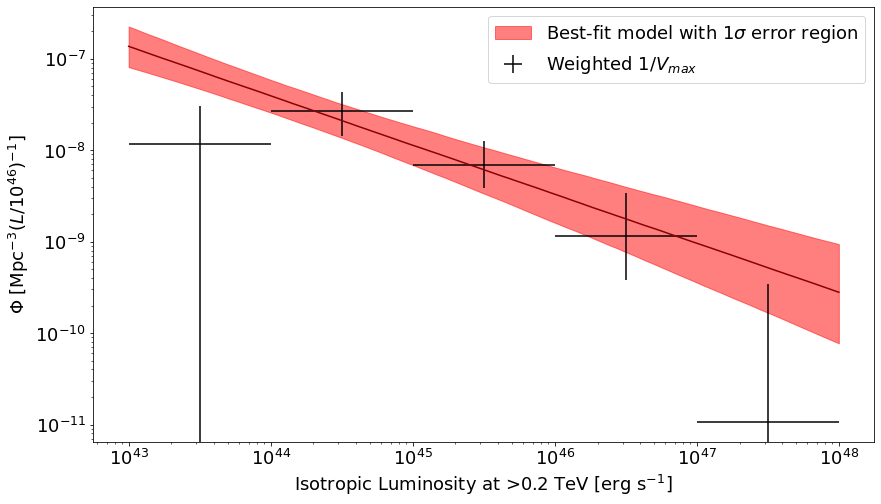

In [21]:
luminosities = np.logspace(min_log10_L, max_log10_L, 100)
overall_density_pts, overall_density_pt_errs = bootstrap(density_pts, density_pt_errs)
overall_v_over_v_max, overall_v_over_v_max_err = bootstrap(v_over_v_max, v_over_v_max_err)
print("{:.03} +- {:.02} sources detected".format(np.mean(num_detected), np.std(num_detected)))
print("<V/V_max> = {:.3f} - {:.3f} + {:.3f}".format(overall_v_over_v_max[0], overall_v_over_v_max_err[0,0],
                                                    overall_v_over_v_max_err[1,0]))    

# Plot MCMC results with 1 sigma confidence interval
lo, med, hi = np.percentile(curves, (16, 50, 84), axis=0)
plt.plot(luminosities, med, color='darkred')
plt.fill_between(luminosities, lo, hi, color='red', alpha=0.5,
                 label=r"Best-fit model with $1\sigma$ error region")

# Plot 1/V_max results
plt.errorbar(bin_centers, overall_density_pts, xerr=bin_errs, yerr=overall_density_pt_errs,
             label=r"Weighted $1/V_{max}$", linestyle='none', color='k')

#plt.title("HBL Local Luminosity Function")
plt.xscale('log')
plt.xlabel("Isotropic Luminosity at >{} TeV".format(e_min.to_value(u.TeV)) + " [erg s$^{-1}$]")
plt.yscale('log')
plt.ylabel("$\Phi$ [Mpc$^{-3} (L/10^{46})^{-1}$]")
plt.legend()
plt.savefig("lf_plot.png", bbox_inches='tight')
plt.savefig("lf_plot.pdf", bbox_inches='tight')

A = 7.6e-09 + 7.348e-09 - 3.89e-09 s / (erg Mpc3)
$\gamma$ = -0.4611 + 0.13 - 0.1298 
k = -5.744 + 5.483 - 7.761 


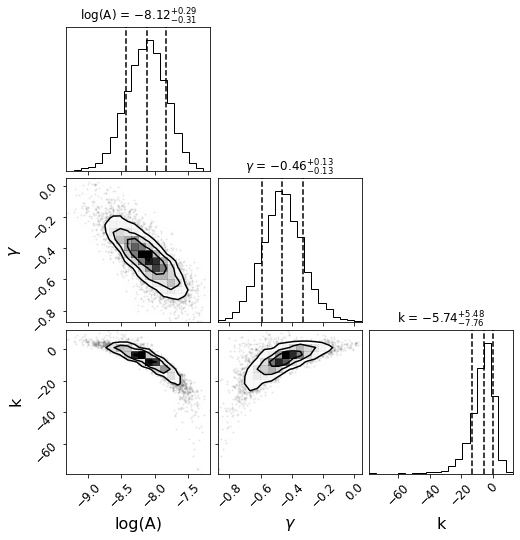

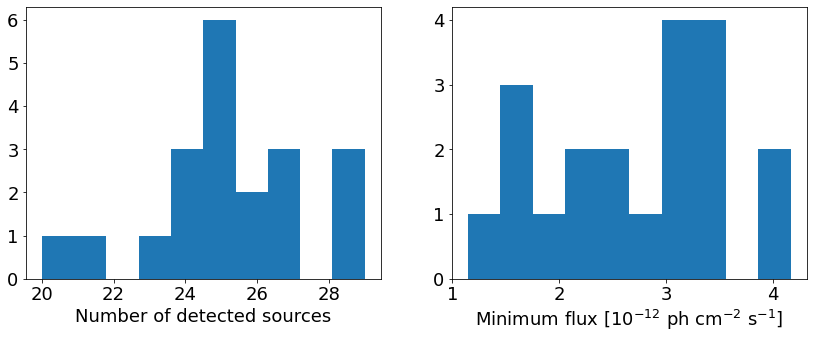

In [22]:
mpl.rcParams.update({'font.size': 12})
labels = ['log(A)' if l == 'A' else l for l in param_labels]
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels=labels, label_kwargs={"fontsize": 16},
                    show_titles=True, title_kwargs={"fontsize": 12})
plt.savefig("cornerplot.png", bbox_inches='tight')
plt.savefig("cornerplot.pdf", bbox_inches='tight')
mpl.rcParams.update({'font.size': 18})


for i, param in enumerate(params):
    lower, median, upper = np.percentile(samples[:, i], [16, 50, 84])
    tfm = param.reverse_transform
    lower, median, upper = tfm(lower), tfm(median), tfm(upper)
    lower_err, upper_err = np.diff((lower, median, upper))
    print("{} = {:.04} + {:.04} - {:.04} {}".format(param.name, median, upper_err, lower_err, param.unit))

    
hist_fig, axes = plt.subplots(1, 2, figsize=(14.0, 5.0))

axes[0].hist(num_detected)
axes[0].set_xlabel("Number of detected sources")

axes[1].hist(min_detected_flux*1e12)
axes[1].set_xlabel("Minimum flux [10$^{-12}$ ph cm$^{-2}$ s$^{-1}$]")
plt.savefig("num_detected_sources.png", bbox_inches='tight')
plt.savefig("num_detected_sources.pdf", bbox_inches='tight')

In [23]:
# Format a table of the selected targets
latex_data = raw_data
latex_data['TeVCat'] = np.where(~np.isnan(latex_data['tevcat_flux_crab']), 'Y', 'N')
latex_data = latex_data.sort_values(by='ra')
latex_data = latex_data.rename(columns={'figure_of_merit': 'FOM', 'source': 'Source', 'Name': '3HSP Name'})
latex = latex_data[['Source', '3HSP Name', 'z', 'FOM', 'TeVCat']].to_latex(index=False, longtable=True,
                                                                           na_rep='')
print(latex)

\begin{longtable}{llrrl}
\toprule
               Source &             3HSP Name &      z &    FOM & TeVCat \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
         1ES 0120+340 &  3HSPJ012308.6+342048 &  0.270 &   6.31 &      N \\
          B3 0133+388 &  3HSPJ013632.6+390559 &        &   6.31 &      N \\
        RGB J0152+017 &  3HSPJ015239.6+014717 &  0.080 &   2.51 &      Y \\
         1ES 0229+200 &  3HSPJ023248.6+201717 &  0.139 &   3.98 &      Y \\
        RGB J0316+090 &  3HSPJ031612.7+090443 &        &   2.51 &      N \\
    1FGL J0333.7+2919 &  3HSPJ033349.0+291631 &        &   2.51 &      N \\
       GB6 J0540+5823 &  3HSPJ054030.0+582338 &        &   2.51 &      N \\
         1ES 0647+250 &  3HSPJ065046.5+250259 &  0.203 &   7.94 &      Y \\
        RGB J0710+591 &  3HSPJ071030.1+590820 &  0.120 &   7.94 &      Y \\
          PGC 2402248 &  3HSPJ073326.8+515355 &  0.065 &   2.51 &      Y \\
         1E